# Utilisation de 3 algorithmes pour une prédiction de prix.

Dans ce Notebook, nous allons dans un premier temps préparer les données afin de n'avoir que les colonnes dont nous aurons besoin. Puis, dans un deuxième temps, nous ferons une recherche des meilleures features a utiliser pour nos algorithmes. La troisième partie de ce Notebook sera dédiée à l'application des trois algorithmes que nous avons choisi, à savoir:  
- Régression Linéaire  
- SG Boost  
- Random Forest  

Nous évaluerons et testerons les performances de nos modèles puis à l'aide d'un GridSearch nous affinerons notre choix sur un seul algorithme et les meilleurs paramètres afin de pouvoir déployer celui-ci sur une application Flask.

### Imports

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from boruta import BorutaPy
import pickle

from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score, max_error


### Chargement du Dataset

In [2]:
df = pd.read_csv('./Data/houses_Madrid_cleaned.csv')

### Début de la préparation des données

On supprime les colonnes qui ne nou servirons pas

In [3]:
cols_to_drop = ["id", "title", "subtitle", "is_exact_address_hidden", "floor", "neighborhood_id", "is_rent_price_known", "is_buy_price_known", "has_fitted_wardrobes", "house_type_id"]
df_cleaned = df.drop(columns=cols_to_drop)

In [4]:
df_cleaned.head()

,Unnamed: 0,sq_mt_built,n_rooms,n_bathrooms,operation,rent_price,buy_price,buy_price_by_area,is_renewal_needed,is_new_development,has_central_heating,has_individual_heating,has_lift,is_exterior,energy_certificate,has_parking,PricePerSqM
0,0,64.0,2,1.0,sale,471,85000,1328,False,False,0,0,False,True,D,False,1308.89
1,1,70.0,3,1.0,sale,666,129900,1856,True,False,0,0,True,True,en trámite,False,1796.68
2,2,94.0,2,2.0,sale,722,144247,1535,False,False,False,True,True,True,no indicado,False,1617.18
3,3,64.0,2,1.0,sale,583,109900,1717,False,False,0,0,True,True,en trámite,False,1617.18
4,4,108.0,2,2.0,sale,1094,260000,2407,False,False,0,0,True,True,en trámite,True,1827.79


Recherche des valeurs uniques pour la colonne 'operation'

In [5]:
unique_value = df_cleaned['operation'].unique()
print(unique_value)

['sale']


Remplacement des valeurs par 1

In [6]:
df_cleaned['operation'] = df_cleaned['operation'].replace('sale', 1)
print(df_cleaned)

       Unnamed: 0  sq_mt_built  n_rooms  n_bathrooms  operation  rent_price  \
0               0         64.0        2          1.0          1         471   
1               1         70.0        3          1.0          1         666   
2               2         94.0        2          2.0          1         722   
3               3         64.0        2          1.0          1         583   
4               4        108.0        2          2.0          1        1094   
...           ...          ...      ...          ...        ...         ...   
19780       21737         78.0        2          2.0          1        1323   
19781       21738         96.0        2          2.0          1        1496   
19782       21739        175.0        4          2.0          1        2081   
19783       21740        289.0        4          3.0          1        2115   
19784       21741         72.0        2          2.0          1        1494   

       buy_price  buy_price_by_area  is_renewal_nee

C:\Users\aurel\AppData\Local\Temp\ipykernel_17704\4109030472.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_cleaned['operation'] = df_cleaned['operation'].replace('sale', 1)


Recherche des variables numériques afin de faire une matrice de corrélation

In [7]:
df_numeric = df_cleaned.select_dtypes(include=['number'])
print(df_numeric)

       Unnamed: 0  sq_mt_built  n_rooms  n_bathrooms  operation  rent_price  \
0               0         64.0        2          1.0          1         471   
1               1         70.0        3          1.0          1         666   
2               2         94.0        2          2.0          1         722   
3               3         64.0        2          1.0          1         583   
4               4        108.0        2          2.0          1        1094   
...           ...          ...      ...          ...        ...         ...   
19780       21737         78.0        2          2.0          1        1323   
19781       21738         96.0        2          2.0          1        1496   
19782       21739        175.0        4          2.0          1        2081   
19783       21740        289.0        4          3.0          1        2115   
19784       21741         72.0        2          2.0          1        1494   

       buy_price  buy_price_by_area  PricePerSqM  


### Début de la recherche des meilleures features

Sélection par matrice de corrélation

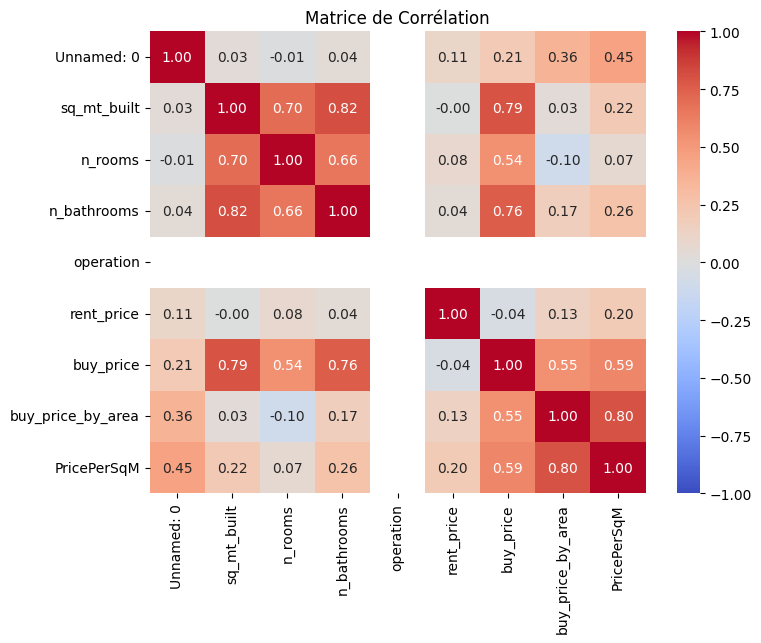

In [8]:
corr_matrix = df_numeric.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)

plt.title('Matrice de Corrélation')

plt.show()

Sélection par Forward Feature Selection

In [9]:
X = df_numeric.drop(columns=['buy_price']) 
y = df_cleaned['buy_price'] 

In [10]:
missing_values_X = X.isna().sum()
print(missing_values_X[missing_values_X > 0])

PricePerSqM    80
dtype: int64


In [11]:
X_cleaned = X.dropna()
y_cleaned = y[X_cleaned.index] 

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y_cleaned, test_size=0.3, random_state=0)

model = LinearRegression()

sfs = SequentialFeatureSelector(model, n_features_to_select='auto', direction='forward', cv=5)

sfs.fit(X_train, y_train)

selected_features = X_cleaned.columns[sfs.get_support()]
print(selected_features)

Index(['sq_mt_built', 'n_rooms', 'rent_price', 'buy_price_by_area'], dtype='object')


Sélection Basée sur l'Importance des Caractéristiques (Boruta)

In [13]:
rf = RandomForestClassifier(n_jobs=-1, max_depth=5, random_state=0)

boruta = BorutaPy(rf, n_estimators='auto', random_state=0)

boruta.fit(X_train, y_train)

important_features = X.columns[boruta.support_]
print(important_features)

Index(['Unnamed: 0', 'sq_mt_built', 'n_rooms', 'n_bathrooms', 'rent_price',
       'buy_price_by_area', 'PricePerSqM'],
      dtype='object')


 Sélection par Importance des Caractéristiques (Trees-based)

In [14]:
rf2 = RandomForestRegressor(n_estimators=100, random_state=0)

rf2.fit(X_train, y_train)

importance = rf2.feature_importances_
feature_importances = pd.Series(importance, index=X.columns).sort_values(ascending=False)
print(feature_importances)

sq_mt_built          0.583333
rent_price           0.359234
buy_price_by_area    0.036047
PricePerSqM          0.019769
n_rooms              0.000905
n_bathrooms          0.000502
Unnamed: 0           0.000210
operation            0.000000
dtype: float64


In [15]:
features = ['sq_mt_built', 'n_rooms', 'buy_price_by_area', 'PricePerSqM']
X = df_cleaned[features]
y = df_cleaned['buy_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

### Application des algorithmes

#### Régression Linéaire

Tout d'abord, on recherche des potentielles valeurs nulles afin de les supprimer. 

In [19]:
# Vérifier les valeurs manquantes dans X_train
missing_values_train = X_train.isna().sum()
print("Valeurs manquantes dans X_train :")
print(missing_values_train[missing_values_train > 0])

# Vérifier les valeurs manquantes dans X_test
missing_values_test = X_test.isna().sum()
print("Valeurs manquantes dans X_test :")
print(missing_values_test[missing_values_test > 0])

# Supprimer les lignes contenant des valeurs manquantes dans X_train et ajuster y_train
X_train = X_train.dropna()
y_train = y_train[X_train.index]

# Supprimer les lignes contenant des valeurs manquantes dans X_test et ajuster y_test
X_test = X_test.dropna()
y_test = y_test[X_test.index]

# Imputer les valeurs manquantes restantes avec la médiane si nécessaire
imputer = SimpleImputer(strategy='median')
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

# Vérification après traitement
print("Vérification après traitement :")
print("Valeurs manquantes dans X_train :")
print(X_train.isna().sum().sum())
print("Valeurs manquantes dans X_test :")
print(X_test.isna().sum().sum())

Valeurs manquantes dans X_train :
Series([], dtype: int64)
Valeurs manquantes dans X_test :
Series([], dtype: int64)
Vérification après traitement :
Valeurs manquantes dans X_train :
0
Valeurs manquantes dans X_test :
0


On applique l'algorithme de Régression Linéaire et on test & évalue ses performances

In [23]:
# Entraînement du modèle de régression linéaire
lr = LinearRegression()
lr.fit(X_train, y_train)

# Prédiction sur le jeu de test
y_pred_lr = lr.predict(X_test)

# Calcul des différentes métriques de performance
# 1. Mean Squared Error (MSE)
mse_lr = mean_squared_error(y_test, y_pred_lr)

# 2. R² Score
r2_lr = r2_score(y_test, y_pred_lr)

# 3. Mean Absolute Error (MAE)
mae_lr = mean_absolute_error(y_test, y_pred_lr)

# 4. Root Mean Squared Error (RMSE)
rmse_lr = np.sqrt(mse_lr)

# 5. Mean Absolute Percentage Error (MAPE)
mape_lr = np.mean(np.abs((y_test - y_pred_lr) / y_test)) * 100

# 6. Explained Variance Score (EVS)
evs_lr = explained_variance_score(y_test, y_pred_lr)

# 7. Max Error
max_err_lr = max_error(y_test, y_pred_lr)

# 8. Adjusted R² Score
n = len(y_test)  # Nombre d'observations dans le jeu de test
p = X_test.shape[1]  # Nombre de variables indépendantes
adjusted_r2_lr = 1 - (1 - r2_lr) * (n - 1) / (n - p - 1)

# Affichage des résultats
print("Régression Linéaire :")
print(f"Mean Squared Error (MSE)           : {mse_lr}")
print(f"Root Mean Squared Error (RMSE)     : {rmse_lr}")
print(f"Mean Absolute Error (MAE)          : {mae_lr}")
print(f"Mean Absolute Percentage Error (MAPE) : {mape_lr:.2f}%")
print(f"R² Score                           : {r2_lr}")
print(f"Adjusted R² Score                  : {adjusted_r2_lr}")
print(f"Explained Variance Score (EVS)     : {evs_lr}")
print(f"Max Error                          : {max_err_lr}")

Régression Linéaire :
Mean Squared Error (MSE)           : 11759187268.582151
Root Mean Squared Error (RMSE)     : 108439.78637281683
Mean Absolute Error (MAE)          : 65657.970351011
Mean Absolute Percentage Error (MAPE) : 19.10%
R² Score                           : 0.9065462777486162
Adjusted R² Score                  : 0.9064829622186356
Explained Variance Score (EVS)     : 0.9065704200665206
Max Error                          : 1237042.8879016964


#### Explications des résultats pour Régression Linéaire

Évaluation du Modèle de Régression Linéaire  

Pour évaluer les performances de notre modèle de régression linéaire, nous avons utilisé plusieurs métriques, dont voici les explications :  

<i><u>Mean Squared Error (MSE) :</u></i>  

MSE mesure la moyenne des carrés des erreurs, c’est-à-dire la différence moyenne au carré entre les valeurs prédites et les valeurs réelles. Une valeur plus faible indique un modèle avec de meilleures performances.  
Ici, le MSE est de 11 759 187 268.58.  
Ce nombre représente la somme des carrés des résidus moyens. Bien que cette valeur semble élevée, il faut la comparer avec l'échelle des prix de l'immobilier pour évaluer sa pertinence.  

<i><u>Root Mean Squared Error (RMSE) :</u></i>  

RMSE est la racine carrée du MSE, ce qui permet d’interpréter cette métrique dans la même unité que la variable cible (buy_price).
Le RMSE obtenu est de 108,439.79. Cela signifie que l'écart type moyen des prévisions de notre modèle par rapport aux prix réels est d'environ 108,439 euros. Un RMSE plus faible indique une meilleure précision.  

<i><u>Mean Absolute Error (MAE) :</u></i>  

MAE mesure l'erreur absolue moyenne entre les valeurs prédites et les valeurs réelles. Elle représente la moyenne des erreurs absolues.
Le MAE est de 65,657.97, ce qui signifie que, en moyenne, les prévisions de notre modèle diffèrent des prix réels d'environ 65,658 euros.  

<i><u>Mean Absolute Percentage Error (MAPE) :</u></i>  

MAPE est un pourcentage qui mesure l'erreur absolue moyenne relative par rapport aux valeurs réelles.
Le MAPE est de 19.10%, ce qui signifie que, en moyenne, les prévisions de notre modèle sont à environ 19.10% des prix réels. Un MAPE plus bas est indicatif d’un modèle plus précis.  

<i><u>R² Score :</u></i>  

R² Score ou coefficient de détermination représente la proportion de la variance dans la variable cible qui est expliquée par le modèle.
Ici, le R² est de 0.9065, ce qui signifie que 90.65% de la variance des prix immobiliers est expliquée par les variables sélectionnées dans notre modèle. Cela indique une très bonne qualité d’ajustement du modèle.  

<i><u>Adjusted R² Score :</u></i>  

R² ajusté est une version modifiée du R² qui tient compte du nombre de variables dans le modèle. Il pénalise les modèles qui incluent trop de variables non significatives.
L'Adjusted R² est de 0.9065, très proche du R² classique. Cela indique que les variables incluses dans le modèle sont pertinentes et contribuent de manière significative à expliquer la variance de la variable cible.  

<i><u>Explained Variance Score (EVS) :</u></i>  

EVS mesure la proportion de variance expliquée par le modèle, similaire au R², mais avec une évaluation légèrement différente des erreurs.
Le score EVS est de 0.9066, très proche du R², ce qui confirme que le modèle explique bien la variabilité des données.  

<i><u>Max Error :</u></i>  

Max Error représente la plus grande erreur absolue observée entre les prédictions du modèle et les valeurs réelles.
La valeur du Max Error est de 1,237,042.89. Cela signifie que la plus grande différence entre un prix prédit et un prix réel est d'environ 1,237,042 euros. Bien que la majorité des erreurs soient plus faibles, cela montre que le modèle peut parfois faire des erreurs importantes pour certains biens.

### Sauvegarde du modèle pour Flask

In [26]:
with open('./flask_app/models/linear_regression_model.pkl', 'wb') as file:
    pickle.dump(lr, file)

#### Forêt aléatoire